Copyright 2019 Google LLC.
SPDX-License-Identifier: Apache-2.0

**Notebook Version** - 1.0.0

In [4]:
# Install datacommons
!pip install --upgrade --quiet git+https://github.com/datacommonsorg/api-python.git@stable-1.x

# Analyzing Income Distribution

The American Community Survey (published by the US Census) annually reports the number of individuals in a given income bracket at the State level. We can use this information, stored in Data Commons, to visualize disparity in income for each State in the US. Our goal for this tutorial will be to generate a plot that visualizes the total number of individuals across a given set of income brackets for a given state. 

Before we begin, we'll setup our notebook

In [0]:
# Import the Data Commons library
import datacommons as dc

# Import other libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

from google.colab import drive

We will also need to provide the API with an API key. See the [Analyzing Statistics in Data Commons Using the Python API](https://colab.research.google.com/drive/1ZNXTHu3J0W3vo9Mg3kNUpk0hnD6Ce1u6#scrollTo=ijxoBhFHjo3Z) to see how to set this up for a Colab Notebook.

In [6]:
# Mount the Drive
drive.mount('/content/drive', force_remount=True)

# REPLACE THIS with the path to your key.
key_path = '/content/drive/My Drive/DataCommons/secret.json'

# Read the key in and provide it to the Data Commons API
with open(key_path, 'r') as f:
  secrets = json.load(f)
  dc.set_api_key(secrets['dc_api_key'])

Mounted at /content/drive


## Preparing the Data

We'll begin by creating a dataframe with states and their total population. We can use **`get_places_in`** to get all States within the United States. We can then call **`get_populations`** and **`get_observations`** to get the population of all persons in each State.

In [7]:
# Initialize a DataFrame holding the USA.
data = pd.DataFrame({'country': ['country/USA']})

# Add a column for states and get their names
data['state'] = dc.get_places_in(data['country'], 'State')
data = dc.flatten_frame(data)

# Get all state names and store it in a column "name"
data['name'] = dc.get_property_values(data['state'], 'name')
data = dc.flatten_frame(data)

# Get StatisticalPopulations representing all persons in each state. 
data['all_pop'] = dc.get_populations(data['state'], 'Person')

# Get the total count of all persons in each population
data['all'] = dc.get_observations(data['all_pop'], 
    'count',
    'measuredValue',
    '2017', 
    measurement_method='CenusACS5yrSurvey')

# Display the first five rows of the table.
data.head(5)

,country,state,name,all_pop,all
0,country/USA,geoId/01,Alabama,dc/p/dft95nqhpkkgd,4850771.0
1,country/USA,geoId/02,Alaska,dc/p/th9yyf8ej6m64,738565.0
2,country/USA,geoId/04,Arizona,dc/p/8hyhwze6s5tn6,6809946.0
3,country/USA,geoId/05,Arkansas,dc/p/rp61n0st0vtr,2977944.0
4,country/USA,geoId/06,California,dc/p/f1jbe2m7w6f58,38982847.0


### Querying for Income Brackets

Next, let's get the population level for each income bracket. The datacommons graph identifies 16 different income brackets. For each bracket and state, we can get the population level. Remember that we first get the StatisticalPopulation, and then a corresponding observation. We'll filter observations to between published in 2017 by the American Community Survey. 

In [8]:
# A list of income brackets
income_brackets = [
  "USDollarUpto10000",
  "USDollar10000To14999",
  "USDollar15000To19999",
  "USDollar20000To24999",
  "USDollar25000To29999",
  "USDollar30000To34999",
  "USDollar35000To39999",
  "USDollar40000To44999",
  "USDollar45000To49999",
  "USDollar50000To59999",
  "USDollar60000To74999",
  "USDollar75000To99999",
  "USDollar100000To124999",
  "USDollar125000To149999",
  "USDollar150000To199999",
  "USDollar200000Onwards",
]

# Add a column containin the population count for each income bracket
for bracket in income_brackets:
  # Get the new column names
  pop_col = '{}_pop'.format(bracket)
  obs_col = bracket
 
  # Create the constraining properties map
  pvs = {'income': bracket}

  # Get the StatisticalPopulation and Observation
  data[pop_col] = dc.get_populations(data['state'], 'Household', 
    constraining_properties=pvs)
  data[obs_col] = dc.get_observations(data[pop_col], 
    'count', 
    'measuredValue', 
    '2017', 
    measurement_method='CenusACS5yrSurvey')

# Display the table
data.head(5)

,country,state,name,all_pop,all,USDollarUpto10000_pop,USDollarUpto10000,USDollar10000To14999_pop,USDollar10000To14999,USDollar15000To19999_pop,USDollar15000To19999,USDollar20000To24999_pop,USDollar20000To24999,USDollar25000To29999_pop,USDollar25000To29999,USDollar30000To34999_pop,USDollar30000To34999,USDollar35000To39999_pop,USDollar35000To39999,USDollar40000To44999_pop,USDollar40000To44999,USDollar45000To49999_pop,USDollar45000To49999,USDollar50000To59999_pop,USDollar50000To59999,USDollar60000To74999_pop,USDollar60000To74999,USDollar75000To99999_pop,USDollar75000To99999,USDollar100000To124999_pop,USDollar100000To124999,USDollar125000To149999_pop,USDollar125000To149999,USDollar150000To199999_pop,USDollar150000To199999,USDollar200000Onwards_pop,USDollar200000Onwards
0,country/USA,geoId/01,Alabama,dc/p/dft95nqhpkkgd,4850771.0,dc/p/k82f7vl1g4xwd,170650.0,dc/p/hrw93dxs7y4y,121688.0,dc/p/q3m0heyyphs14,116273.0,dc/p/9c6gwfklz5pdd,112406.0,dc/p/xlm581r7zpx51,102590.0,dc/p/4fgqdmf6e4stc,100223.0,dc/p/8j3sfby51kqtc,92139.0,dc/p/46tg31n5kyvj9,88987.0,dc/p/lq36bnvmybekc,76070.0,dc/p/tn6m8wemxs8p8,149492.0,dc/p/mgbnwm5rld8wg,176589.0,dc/p/w2b2s0967krx5,206436.0,dc/p/x2ylx680g94e,133618.0,dc/p/wphpwpkew18c1,76939.0,dc/p/p1zgxd7fdcqs,71748.0,dc/p/3hr2p57hjdrpg,60847.0
1,country/USA,geoId/02,Alaska,dc/p/th9yyf8ej6m64,738565.0,dc/p/glg0lwn58bgc6,9650.0,dc/p/hw4lqlcj11fgf,7838.0,dc/p/w4gre87nr3p47,8013.0,dc/p/4hhydjfw16c43,8854.0,dc/p/ceecx2c5xbgn9,8383.0,dc/p/426jehzy44g3f,8914.0,dc/p/pefxk2krk2qp1,8998.0,dc/p/prskbr4e1sfyb,10163.0,dc/p/d5er7t9wwc66d,8536.0,dc/p/ktvrdr1gknnhf,18810.0,dc/p/plzhkpjz6wr78,26224.0,dc/p/fdc874r6enj2c,36745.0,dc/p/15sg657df7j5,29925.0,dc/p/7e3m1jl4r8052,19752.0,dc/p/3kv7sn1ldgwm2,23596.0,dc/p/jb4z82wlf0126,18135.0
2,country/USA,geoId/04,Arizona,dc/p/8hyhwze6s5tn6,6809946.0,dc/p/6rf6dsjxvbr5f,178384.0,dc/p/hll4exlmk8jtc,118676.0,dc/p/b6tpkyz295xm8,123075.0,dc/p/lx28sr11tdqq7,131903.0,dc/p/efkmmwsclfnfh,127741.0,dc/p/33edcg1c0100h,127570.0,dc/p/17q967xck0c01,119431.0,dc/p/6m7ch4wy4b7xb,125103.0,dc/p/385p6jvm97wxg,107245.0,dc/p/3f837b5vqk8h3,208318.0,dc/p/696jjk7e08hh1,254294.0,dc/p/pwcgh30nt42r1,303811.0,dc/p/nghgrgdm0tpv7,200818.0,dc/p/6blwss6nsxz09,119347.0,dc/p/fltk974mm3kj4,119778.0,dc/p/2k3tkfp68b293,116817.0
3,country/USA,geoId/05,Arkansas,dc/p/rp61n0st0vtr,2977944.0,dc/p/vgcvlmnj54ydh,97226.0,dc/p/7ww6w7t4xvlk7,78535.0,dc/p/efynsmzwc5823,74451.0,dc/p/jp3jptvfwn9nd,75194.0,dc/p/66tt8rr0fm3bb,70211.0,dc/p/23qm6tpqyt2b5,67958.0,dc/p/z932k4dhz67dc,61588.0,dc/p/fct1f5rb8ev42,60814.0,dc/p/q3zges6zxwgmh,50978.0,dc/p/rd41ltemvb8z8,95836.0,dc/p/dfbfs6lbx10vb,111618.0,dc/p/hzy4wfxdpvzfh,120034.0,dc/p/yc2terhkh6d78,72752.0,dc/p/w4fte21fpn4wd,40780.0,dc/p/bl9k2gysnpb69,35900.0,dc/p/bjjw2gv79ev25,33416.0
4,country/USA,geoId/06,California,dc/p/f1jbe2m7w6f58,38982847.0,dc/p/dgbhzzzkwdj28,694945.0,dc/p/xddppkel4sgr9,604666.0,dc/p/qgyd003dbv7p6,536203.0,dc/p/xzf8djy5dt8bd,568994.0,dc/p/7x9127m9stem7,523563.0,dc/p/v6wcvfjc3bvfd,539988.0,dc/p/qn2fz1xggyhkc,500571.0,dc/p/pkbcstte9lq28,509113.0,dc/p/mfy8k6ejt1k0d,456152.0,dc/p/1gy8f20jdlwng,895758.0,dc/p/g9ly5ee1c7bf3,1199773.0,dc/p/kc59r4x1tedq4,1568843.0,dc/p/3c9483vks6ev7,1206637.0,dc/p/bc518fz7gl1f6,818690.0,dc/p/cx6fr5lfvhtx5,1008388.0,dc/p/2vdzt089wp0c1,1255844.0


Let's limit the size of this DataFrame by selecting columns with only the State name and Observations.

In [9]:
# Select columns that will be used for plotting
data = data[['name', 'all'] + income_brackets]

# Display the table
data.head(5)

,name,all,USDollarUpto10000,USDollar10000To14999,USDollar15000To19999,USDollar20000To24999,USDollar25000To29999,USDollar30000To34999,USDollar35000To39999,USDollar40000To44999,USDollar45000To49999,USDollar50000To59999,USDollar60000To74999,USDollar75000To99999,USDollar100000To124999,USDollar125000To149999,USDollar150000To199999,USDollar200000Onwards
0,Alabama,4850771.0,170650.0,121688.0,116273.0,112406.0,102590.0,100223.0,92139.0,88987.0,76070.0,149492.0,176589.0,206436.0,133618.0,76939.0,71748.0,60847.0
1,Alaska,738565.0,9650.0,7838.0,8013.0,8854.0,8383.0,8914.0,8998.0,10163.0,8536.0,18810.0,26224.0,36745.0,29925.0,19752.0,23596.0,18135.0
2,Arizona,6809946.0,178384.0,118676.0,123075.0,131903.0,127741.0,127570.0,119431.0,125103.0,107245.0,208318.0,254294.0,303811.0,200818.0,119347.0,119778.0,116817.0
3,Arkansas,2977944.0,97226.0,78535.0,74451.0,75194.0,70211.0,67958.0,61588.0,60814.0,50978.0,95836.0,111618.0,120034.0,72752.0,40780.0,35900.0,33416.0
4,California,38982847.0,694945.0,604666.0,536203.0,568994.0,523563.0,539988.0,500571.0,509113.0,456152.0,895758.0,1199773.0,1568843.0,1206637.0,818690.0,1008388.0,1255844.0


## Analyzing the Data

Let's plot our data as a histogram. Notice that the income ranges as tabulated by the US Census are not equal. At the low end, the range is 0-9999, whereas, towards the top, the range 150,000-199,999 is five times as broad! We will make the width of each of the columns correspond to their range, and will give us an idea of the total earnings, not just the number of people in that group.

First we provide code for generating the plot.

In [0]:
# Histogram bins
label_to_range = {
  "USDollarUpto10000": [0, 9999],
  "USDollar10000To14999": [10000, 14999],
  "USDollar15000To19999": [15000, 19999],
  "USDollar20000To24999": [20000, 24999],
  "USDollar25000To29999": [25000, 29999],
  "USDollar30000To34999": [30000, 34999],
  "USDollar35000To39999": [35000, 39999],
  "USDollar40000To44999": [40000, 44999],
  "USDollar45000To49999": [45000, 49999],
  "USDollar50000To59999": [50000, 59999],
  "USDollar60000To74999": [60000, 74999],
  "USDollar75000To99999": [75000, 99999],
  "USDollar100000To124999": [100000, 124999],
  "USDollar125000To149999": [125000, 149999],
  "USDollar150000To199999": [150000, 199999],
  "USDollar200000Onwards": [250000, 300000],
}
bins = [
  0, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 60000, 
  75000, 100000, 125000, 150000, 250000
]

def plot_income(data, state_name):
  # Assert that "state_name" is a valid state name
  frame_search = data.loc[data['name'] == state_name].squeeze()
  if frame_search.shape[0] == 0:
    print('{} does not have sufficient income data to generate the plot!'.format(state_name))
    return
  
  # Print the resulting series
  data = frame_search[2:]
  
  # Calculate the bar lengths
  lengths = []
  for bracket in income_brackets:
    r = label_to_range[bracket] 
    lengths.append(int((r[1] - r[0]) / 18))
  
  # Calculate the x-axis positions
  pos, total = [], 0
  for l in lengths:
    pos.append(total + (l // 2))
    total += l
  
  # Plot the histogram
  plt.figure(figsize=(12, 10))
  plt.xticks(pos, income_brackets, rotation=90)
  plt.grid(True)
  plt.bar(pos, data.values, lengths, color='b', alpha=0.3)
  
  # Return the resulting frame.
  return frame_search

We can then call this code with a state to plot the income bracket sizes.

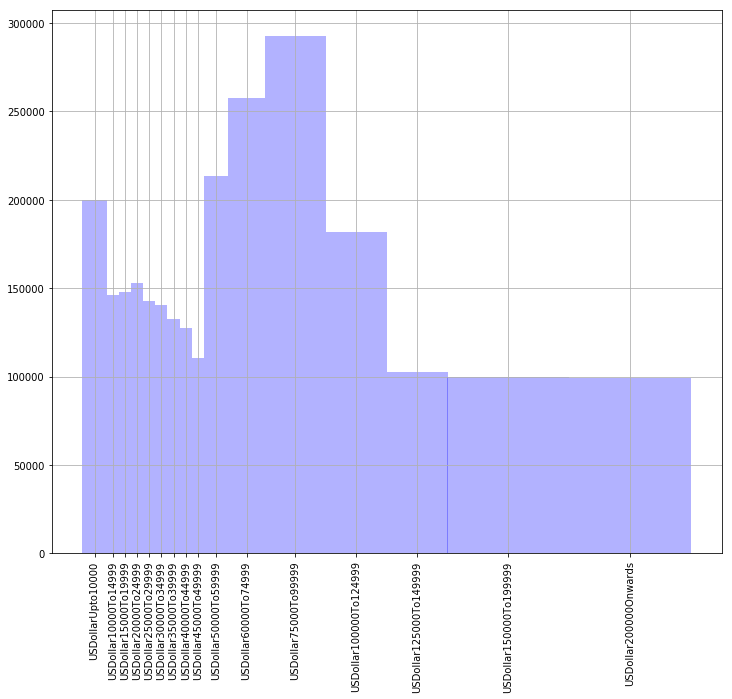

In [11]:
#@title Enter State to plot { run: "auto" }
state_name = "Tennessee" #@param ["Missouri", "Arkansas", "Arizona", "Ohio", "Connecticut", "Vermont", "Illinois", "South Dakota", "Iowa", "Oklahoma", "Kansas", "Washington", "Oregon", "Hawaii", "Minnesota", "Idaho", "Alaska", "Colorado", "Delaware", "Alabama", "North Dakota", "Michigan", "California", "Indiana", "Kentucky", "Nebraska", "Louisiana", "New Jersey", "Rhode Island", "Utah", "Nevada", "South Carolina", "Wisconsin", "New York", "North Carolina", "New Hampshire", "Georgia", "Pennsylvania", "West Virginia", "Maine", "Mississippi", "Montana", "Tennessee", "New Mexico", "Massachusetts", "Wyoming", "Maryland", "Florida", "Texas", "Virginia"]
result = plot_income(data, state_name)

# Show the plot
plt.show()

and we can display the raw table of values.

In [12]:
# Additionally print the table of income bracket sizes 
result

name                        Tennessee
all                       6.59738e+06
USDollarUpto10000              200034
USDollar10000To14999           146404
USDollar15000To19999           147660
USDollar20000To24999           152867
USDollar25000To29999           142625
USDollar30000To34999           140211
USDollar35000To39999           132737
USDollar40000To44999           127434
USDollar45000To49999           110586
USDollar50000To59999           213266
USDollar60000To74999           257530
USDollar75000To99999           292764
USDollar100000To124999         181732
USDollar125000To149999         102356
USDollar150000To199999          99880
USDollar200000Onwards           99108
Name: 42, dtype: object

This is only the beginning! What else can you analyze? For example, you could try computing a measure of income disparity in each state (see [Gini Coefficient](https://en.wikipedia.org/wiki/Gini_coefficient)).

You could then expand the dataframe to include more information and analyze how attributes like education level, crime, or even weather effect income disparity.

